# Building alternative pipeline

* Prepare Hough transform based only on wire information (= energy, time, radial distance)
* Build predictions based on Hough, local information, and local information of left/right neighbors


In [1]:
%pylab inline
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hits import AllHits
hits = AllHits('../data/signal_TDR.root')

In [3]:
from tracking import Hough
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve

### Collect (Raw) Wire Features 

In [4]:
right_neighs = numpy.array([hits.cydet.shift_wire(wire, 1) for wire in range(hits.cydet.n_points)])
left_neighs = numpy.array([hits.cydet.shift_wire(wire, -1) for wire in range(hits.cydet.n_points)])

In [5]:
# Energy deposits
deposits = numpy.vstack(hits.get_energy_deposits(i) for i in range(hits.n_events))
deposits *= 100 # to avoid small numbers for GBRT
# Time after triggering that signal waveforms starts
rel_time = numpy.vstack(hits.get_relative_time(i) for i in range(hits.n_events))
# Truth Values
labels = numpy.vstack(hits.get_hit_types(i) for i in range(hits.n_events))
# Layer ID of hit wires
layer_id = numpy.vstack(hits.cydet.point_rhos for i in range(hits.n_events))

In [6]:
labels.shape, deposits.shape

((3445, 4482), (3445, 4482))

## Train/test splitting 

In [7]:
from sklearn.cross_validation import train_test_split
rest, sample_3 = train_test_split(range(len(labels)), train_size=0.6, test_size=0.3)
sample_1, sample_2 = train_test_split(rest, train_size=0.5, test_size=0.5)

## Features for Wire GBDT

In [8]:
from collections import OrderedDict
features = OrderedDict()
# Wire features
features['deposit'] = deposits * 100
features['rel_time'] = rel_time
features['layer_id'] = layer_id

# LR-Neighbour Features
features['r_deposit'] = (deposits * 100)[:, right_neighs]
features['r_rel_time'] = rel_time[:, right_neighs]
features['l_deposit'] = (deposits * 100)[:, left_neighs]
features['l_rel_time'] = rel_time[:, left_neighs]

# Truth values
features['labels'] = labels

In [9]:
# Define Data
train_features = features.keys()[:-1]
data = numpy.dstack(features.values())
print data.shape

(3445, 4482, 8)


## Define new interface for 3D data [event_index, wire_index, feature_index]

In [10]:
import pandas
def train_classifier(data, features, train_events, train_wires, train_target, classifier):
    """
    Function to flatten out wires from [event, wires] to [all_wires]
    data - original dataset with prepared features
    features - names of features in dataset
    train_events - ids of events 
    train_wires - which wires to use (boolean numpy.array of shape [n_events, n_wires])
    train_target - numpy.array of shape [n_events, n_wires] with zeros and ones, and whatever in 
    classifier - rep classifier to be used
    """
    # Get the indecies of the wires and flatten
    train_wires = train_wires[train_events].flatten()
    # Flatten the data to [all_wires, n_features], only use wires that are training wires
    train_data = data[train_events].reshape(-1, data.shape[-1])[train_wires, :]
    # Define the data frame
    train_data = pandas.DataFrame(data=train_data, columns=features)
    # Get labels for the wires
    train_target = train_target[train_events].flatten()[train_wires]
    # Train the classifieir
    classifier.fit(train_data, train_target)
    return classifier

def predict_classifier(data, features, classifier, apply_mask, default_value=0.):
    """
    data - original data [n_samples, n_wires, n_features]
    features - features of it
    apply_mask - numpy.array of shape [n_samples, n_wires]
    classifier - used classifier
    """
    # Select which wires will be predicted
    apply_mask = apply_mask.flatten()
    # Flatten the test data
    test_data = pandas.DataFrame(data=data.reshape([-1, data.shape[-1]]), columns=features)
    # Allow for a default value on top of the result
    result = numpy.zeros(len(test_data)) + default_value
    # Apply the wire mask to the result
    result[apply_mask] = classifier.predict_proba(test_data[apply_mask])[:, 1]
    # Return the signal probabilities
    return result.reshape(data.shape[:2])

## NeighbourLevel GBDT

In [11]:
from rep.estimators import SklearnClassifier
from rep.metaml.factory import ClassifiersFactory
from sklearn.ensemble import GradientBoostingClassifier

# Training
neigh_gbdt = train_classifier(data=data, features=features.keys(), train_events=sample_1, 
    train_wires=features['labels'] != 0, 
    train_target=2 - features['labels'], 
    classifier=SklearnClassifier(GradientBoostingClassifier(n_estimators=10), features=train_features))

In [12]:
# Test data for the wire level GBDT
data_2 = data[sample_2]
pred_2 = predict_classifier(data_2, features, neigh_gbdt, 
                               apply_mask=data_2[:, :, -1] != 0)

In [13]:
# Get training output data for the wire level GBDT
data_1 = data[sample_1]
pred_1 = predict_classifier(data_1, features, neigh_gbdt, 
                               apply_mask=data_1[:, :, -1] != 0)

## Testing hough  

In [14]:
def setup_plot_for_detector(size=(15, 15)):
    figsize(*size)
    axes(polar=True)
    # set appropriate
    ylim(0, 85)   

In [15]:
def get_labels(features, sample):
    # Signal, background, and nothing labels
    triplelabels = features['labels'][sample].flatten()
    # Define signal as one, nothing or background as zero
    binary_labels = numpy.take([0, 1, 0], triplelabels)
    return triplelabels, binary_labels

In [16]:
triplelabels_2, binary_labels_2 = get_labels(features, sample_2)
# Before Hough
before_hough_2 = pred_2.flatten()
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = (triplelabels_2 != 0) * abs(binary_labels_2 - before_hough_2) ** 2

### real quality and quality with weights increased for poorly recognized events.
Second scoring is used later to measure quality of Hough transform

In [17]:
print roc_auc_score(binary_labels_2, before_hough_2, sample_weight=(triplelabels_2 != 0))
print roc_auc_score(binary_labels_2, before_hough_2, sample_weight=problem_weights_2)

0.988524112074
0.712080356625


### collecting geometry information for plots

In [18]:
hough = Hough(hits)
wire_rhos, wire_phis = hits.cydet.get_points_rhos_and_phis()
wire_xs, wire_ys = hits.cydet.get_points_xs_and_ys()
track_rhos, track_phis = hough.track.get_points_rhos_and_phis()
track_xs, track_ys = hough.track.get_points_xs_and_ys()

### building correspondence matrix separately for even/odd, for several radii

In [19]:
default = [[31.5, 34, 34.5, 2]]
submatrices = []

# Define even and odd layer wires
even_wires = hits.cydet.point_pol != 1
odd_wires = hits.cydet.point_pol == 1

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = Hough(hits, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax, sig_rho_sgma=rsgma)
    corresp = hough.correspondence
    
    # Make even and odd layer hough matricies
    corresp_odd = corresp.copy()
    corresp_odd[even_wires, :] = 0
    corresp_even = corresp.copy()
    corresp_even[odd_wires, :] = 0
    
    # Append the two matricies
    submatrices.append(corresp_odd)
    submatrices.append(corresp_even)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [20]:
new_correspondence.shape, new_correspondence.nnz

((4482, 5634), 264565)

In [21]:
def is_max(data, neighs_matrix, alpha=10):
    """
    This is soft version of 'is_max' rule.
    Strong version returns 1 it it is max among neighbors, 0 otherwise.
    The greater alpha, the closer we are to 'strong' version
    """
    exponents = numpy.exp(alpha * data)
    n_parts = data.shape[1] // neighs_matrix.shape[1]
    assert n_parts * neighs_matrix.shape[1] == data.shape[1]
    full_neigh = sparse.block_diag([neighs_matrix] * n_parts, format='csr')
    return exponents / full_neigh.dot(exponents.T).T

In [22]:
# normalized nearest neighbors matrix for tracks.
nns = hough.track.point_neighbours 
nns = nns + sparse.identity(nns.shape[1])
nns = nns.dot(hough.track.lr_neighbours) + hough.track.lr_neighbours 
nns = sparse.csr_matrix(nns / nns.sum(axis=1))

### Since hough has some parameters,  those should be fitted on train data
so introducing special class

In [23]:
class HoughTransform(object):
    def __init__(self, hough_matrix, track_neighs_matrix, min_percentile=0.97, alpha=12.):
        self.hough_matrix = hough_matrix
        self.min_percentile = min_percentile
        self.alpha = alpha
        self.normed_corresp = sparse.csr_matrix(hough_matrix / (hough_matrix.sum(axis=1) + 50.))
        self.track_neighs_matrix = track_neighs_matrix
        
    def fit(self, X):
        self.n_features = X.shape[1]
        
        self.original_mean = X.mean()
        original = X - self.original_mean

        hough_images = self.normed_corresp.T.dot(original.T).T
        
        x = numpy.linspace(0, 1, 200) ** 0.5
        self.percentiles = numpy.percentile(hough_images.flatten(), x * 100)
        self.values_at_percentiles = numpy.maximum(0., x - self.min_percentile) / (1. - self.min_percentile)

        hough_images = hough_images * is_max(hough_images, neighs_matrix=self.track_neighs_matrix, alpha=self.alpha)
        hough_images = numpy.exp(self.alpha * hough_images)
        self.mean_hough = hough_images.mean()
        
        return self
    
    def transform(self, X):
        original = X - self.original_mean

        hough_images = self.normed_corresp.T.dot(original.T).T
        hough_images = numpy.interp(hough_images, self.percentiles, self.values_at_percentiles)        
        
        hough_images = hough_images * is_max(hough_images, neighs_matrix=self.track_neighs_matrix, alpha=self.alpha)
        hough_images = numpy.exp(self.alpha * hough_images)
        hough_images -= self.mean_hough
        
        # TODO: other matrix here?
        after_hough = self.normed_corresp.dot(hough_images.T).T
        
        return after_hough, hough_images    

### visualizing Hough

In [24]:
hough_transformer = HoughTransform(hough_matrix=new_correspondence, track_neighs_matrix=nns)
hough_transformer.fit(pred_1)

#for event_id in [1, 2, 3, 4, 5]:
#    setup_plot_for_detector()
#    colored_answers = numpy.take(['w', 'b', 'w'], test_data[event_id, :, -1].astype('int64').flatten()) 
#    scatter(wire_phis, wire_rhos, c=colored_answers, alpha=0.5, s=50, linewidths=0)
#    after_hough, hough_image = hough_transformer.transform(test_pred[[event_id], :])
#    scatter(wire_phis, wire_rhos, c=after_hough, s=10, linewidths=0)
#    scatter(track_phis, track_rhos, c=hough_image.flatten()[:len(track_phis)], cmap='Blues')
#    show()
    

In [25]:
# searching for optimal parameters
# for min_percentile in [0.96, 0.97, 0.98]:
#     for alpha in [3, 5, 10]:
#         print "-----", min_percentile, alpha
#         hough_transformer = HoughTransform(hough_matrix=new_correspondence, track_neighs_matrix=nns, 
#                                            alpha=alpha, min_percentile=min_percentile)
#         hough_transformer.fit(train_pred)
#         after_hough, _ = hough_transformer.transform(test_pred)
#         print roc_auc_score(test_binary_labels, after_hough.flatten(), sample_weight=test_problematic_weights)

## Traning second classifier

In [26]:
hough_transformer = HoughTransform(hough_matrix=new_correspondence, track_neighs_matrix=nns)
hough_transformer.fit(pred_1)

In [27]:
# Define full features, but do not keep labels row, this is last by convention
features_full = OrderedDict()

# Wire features
features_full['deposit'] = deposits * 100
features_full['rel_time'] = rel_time
features_full['layer_id'] = layer_id

# LR-Neighbour Features
features_full['r_deposit'] = (deposits * 100)[:, right_neighs]
features_full['r_rel_time'] = rel_time[:, right_neighs]
features_full['l_deposit'] = (deposits * 100)[:, left_neighs]
features_full['l_rel_time'] = rel_time[:, left_neighs]

#Add in Hough transform
with_hough_predictions = predict_classifier(data, features, neigh_gbdt, apply_mask=data[:, :, -1] != 0)
features_full['hough'], _ = hough_transformer.transform(with_hough_predictions)

# Truth values
features_full['labels'] = labels

In [28]:
data_full = numpy.dstack(features_full.values())
train_features_full = features_full.keys()[:-1]

In [29]:
full_gbdt = train_classifier(data=data_full, features=features_full.keys(), train_events=sample_2, 
    train_wires=features_full['labels'] != 0, 
    train_target=2 - features_full['labels'], 
    classifier=SklearnClassifier(GradientBoostingClassifier(n_estimators=100, subsample=0.7), features=train_features_full))

In [30]:
data_full_3 = data_full[sample_3]
pred_full_3 = predict_classifier(data_full_3, features_full.keys(), full_gbdt, 
                                    apply_mask=data_full_3[:, :, -1] != 0)
triplelabels_3, binary_labels_3 = get_labels(features, sample_3)

## Final quality of signal vs bck wires

In [31]:
print roc_auc_score(binary_labels_3, pred_full_3.flatten(), sample_weight=(triplelabels_3 != 0))

0.99877755466


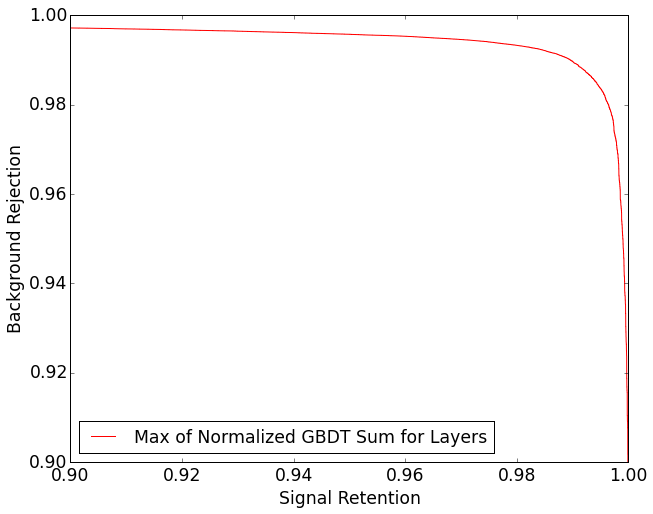

In [32]:
fpr, tpr, values =  roc_curve(binary_labels_3, pred_full_3.flatten(), sample_weight=(triplelabels_3 != 0))

figsize(10,8)
ax = plt.subplot(111)
plt.xticks(fontsize ='xx-large')
plt.yticks(fontsize ='xx-large') 
plt.xlabel('Signal Retention', fontsize='xx-large')
plt.ylabel('Background Rejection', fontsize='xx-large')
plt.xlim([0.90,1.])
plt.ylim([0.90,1.])
ax.plot(tpr, 1-fpr, label="Max of Normalized GBDT Sum for Layers")

plt.legend(fontsize='xx-large',loc=0)

In [33]:
point_perc_index = numpy.where(tpr > 0.999)[0][0]
print "{0:.5f}, {1:.5f}".format(tpr[point_perc_index], 1-fpr[point_perc_index])

one_perc_index = numpy.where(tpr > 0.99)[0][0]
print "{0:.5f}, {1:.5f}".format(tpr[one_perc_index], 1-fpr[one_perc_index])

five_perc_index = numpy.where(tpr > 0.95)[0][0]
print "{0:.5f}, {1:.5f}".format(tpr[five_perc_index], 1-fpr[five_perc_index])

0.99900, 0.94990
0.99001, 0.98967
0.95003, 0.99577


## Final quality of track finding vs track purity


In [34]:
def plot_output(data, pred):
    # Plot the distribution
    sig = numpy.where(data[: , : , -1] == 1) 
    bkg = numpy.where(data[: , : , -1] == 2) 

    figsize(10,10)
    plt.xticks(fontsize ='xx-large')
    plt.yticks(fontsize ='xx-large') 
    plt.xlabel('Output of Wire GBDT', fontsize='xx-large')
    plt.ylabel('Normalized Distribution of Hit Wires', fontsize='xx-large')

    plt.hist(pred[sig], normed=True, bins=50, label='Signal', log=False)
    plt.hist(pred[bkg], normed=True, bins=50, label='Background', log=False)

    plt.legend(fontsize='xx-large')

In [35]:
# Test again on the training data
data_3 = data[sample_3]
pred_3 = predict_classifier(data_3, features.keys(), neigh_gbdt, 
                                    apply_mask=data_3[:, :, -1] != 0)
#plot_output(finding_data, finding_pred)

## Drawing Outputs

In [36]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

In [37]:
def draw_output(signal_hits, background_hits, size=30):
    setup_plot_for_detector(size=(12,12))
    ax = plt.subplot(111, polar=True)
    ax.scatter(wire_phis, wire_rhos, marker='.', s=5)
    ax.scatter(wire_phis[signal_hits],wire_rhos[signal_hits], s=size, marker='o', color='red')
    ax.scatter(wire_phis[background_hits],wire_rhos[background_hits], marker='o', c='b', s=size)
    show()

In [38]:
def add_circle(x, y, radius, spread=0, color="green"):
    target_radius = plt.Circle((x, y), radius, transform=ax.transData._b, 
                               color=color, fill=False,)
    gca().add_artist(target_radius)
    if spread!=0:
        target_spread = plt.Circle((x, y), radius, 
                                   transform=ax.transData._b, color="green", 
                                   alpha=0.025, fill=False, lw=spread)
        gca().add_artist(target_spread)    

In [39]:
def norm_size(bdt_guess, size=30):
    return float(size)*bdt_guess/max(bdt_guess)

/home/elg112/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


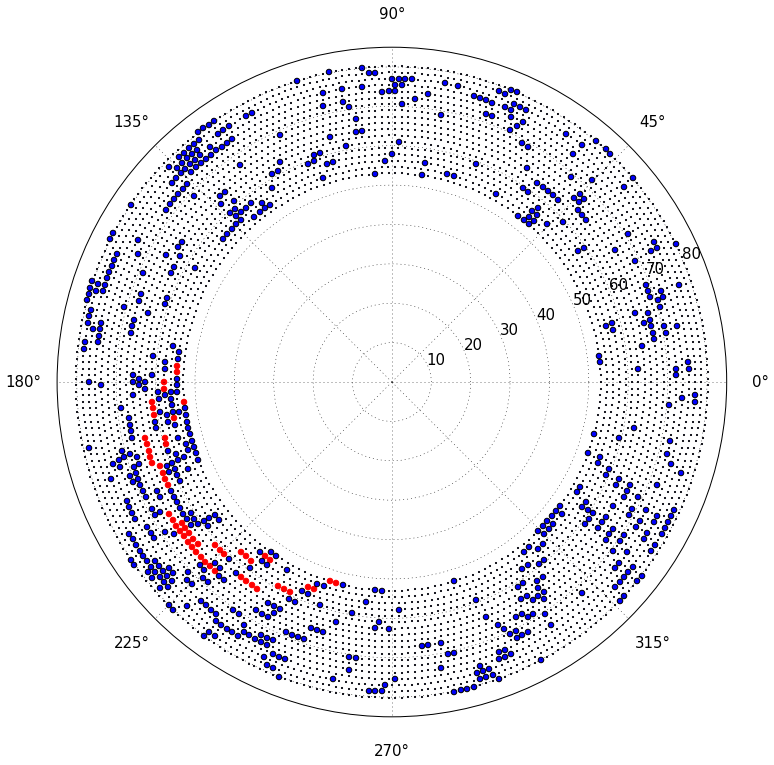

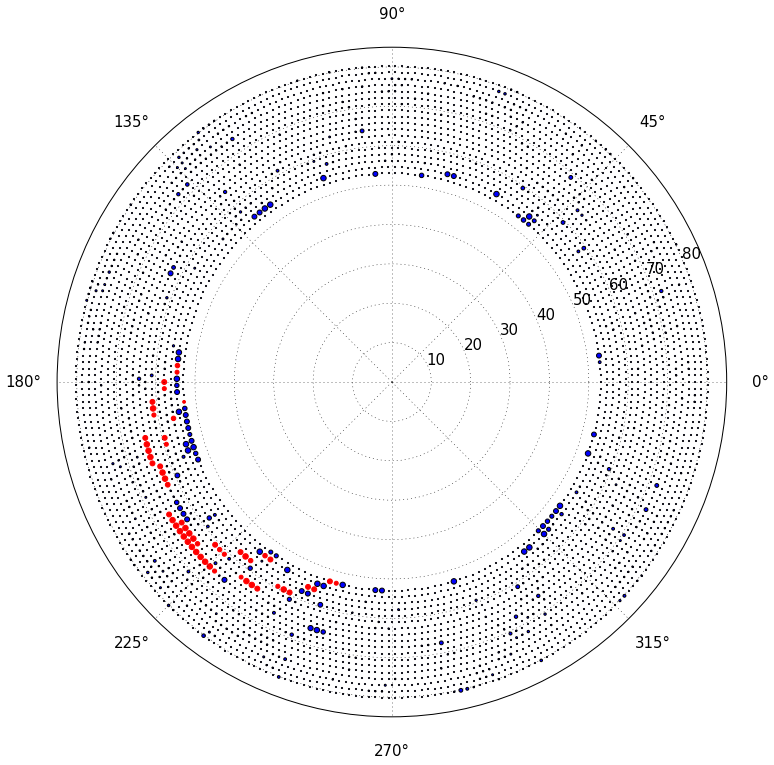

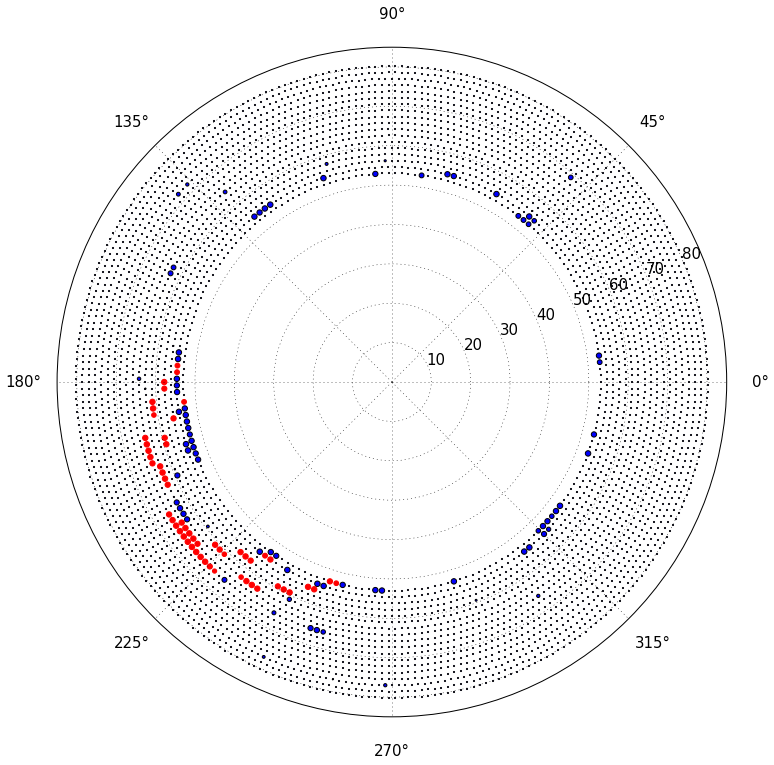

In [40]:
event = 13
to_plot = data_3[event]

sig = np.where(to_plot[:, -1] == 1)[0]
bkg =  np.where(to_plot[:, -1] == 2)[0]

first_gbdt = pred_3[event,np.append(sig,bkg)]
second_gbdt = pred_full_3[event,np.append(sig,bkg)]


draw_output(sig, bkg)
draw_output(sig, bkg, size=norm_size(first_gbdt))
draw_output(sig, bkg, size=norm_size(second_gbdt))